In [12]:
import json
import schema_defs
import pandas as pd

df = pd.DataFrame(columns=schema_defs.columns)

# Mapping to fix formating differances and typos between game data and darkerdb info
def effect_id_to_max(effect_key, effect_data):
    max_field = schema_defs.effect_mapping.get(effect_key)
    if max_field is None:
        print(f"Effect key not found: [{effect_key}]")
        print(schema_defs.effect_mapping)
        return None
    max_val = effect_data.get(max_field)
    if max_val is None:
        print(f"Missing max value for [{effect_key}]")
    return max_val

rows = []
with open(schema_defs.OUTPUT_FILE, "r", encoding="utf-8") as file:
    for line in file:
        k = json.loads(line)
        items = k["chats"][0]["chatData"]["chatDataPieceArray"]
        
        message = ""
        weapon_info = None
        weapon_count = 0

        # Collect message and check weapons
        for item in items:
            info = item.get("chatDataPieceItem", {})
            if info.get("uid") == "0":
                message += item.get("chatStr", "")

            iid = info.get("iid")
            if iid in schema_defs.weapon_ids:
                weapon_count += 1
                if weapon_count > 1:
                    break
                weapon_info = info

        # Only add row if exactly one weapon and has message
        if weapon_count == 1 and weapon_info and message.strip():
            name, rarity_str = weapon_info["iid"].split("_")
            rarity = int(rarity_str[0])

            row = {
                "message": message,
                "name": name,
                "rarity": rarity,
                "id": weapon_info["iid"]
            }
            
            for pp in weapon_info.get("pp", []):
                col = "pp_" + pp["pid"]
                max_val = effect_id_to_max(col, schema_defs.weapon_dict[weapon_info["iid"]]) 
                value = pp["pv"] / max_val
                if value > 1.0:
                    value = value / 10 # format percentages
                    
                row[col] = value
            for sp in weapon_info.get("sp", []):
                col = "sp_" + sp["pid"]
                max_val = effect_id_to_max(col, schema_defs.weapon_dict[weapon_info["iid"]])
                value = sp["pv"] / max_val
                if value > 1.0:
                    value = value / 10 # format percentages
                row[col] = value

            rows.append(row)

df = pd.DataFrame(rows).drop_duplicates().fillna(0)
df.head()

,message,name,rarity,id,pp_Effect_PhysicalWeaponDamage,pp_Effect_MoveSpeed,sp_Effect_Luck,sp_Effect_MagicalDamageBonus,sp_Effect_MemoryCapacityAdd,sp_Effect_PhysicalWeaponDamageAdd,...,sp_Effect_DemonDamageMod,sp_Effect_UndeadReductionMod,sp_Effect_MemoryCapacityBonus,sp_Effect_MagicalHealing,sp_Effect_MaxHealthBonus,sp_Effect_Will,sp_Effect_MagicPenetration,sp_Effect_MagicalPower,sp_Effect_PhysicalDamageReduction,pp_Effect_ArmorRating
0,61+2 wts 2db+2full or offer,Halberd,8,Halberd_8001,1.0,1.0,0.966667,0.583333,0.50,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4db,CrystalSword,8,CrystalSword_8001,1.0,1.0,0.000000,0.000000,0.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,WTT fang or claw,CrystalBall,8,CrystalBall_8001,0.0,1.0,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,offer,Halberd,8,Halberd_8001,1.0,1.0,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2lad,StilettoDagger,8,StilettoDagger_8001,1.0,1.0,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
import re

# Convert messages to number of db
def message_to_dbs(text):
    text = text.lower().replace(" ", "").replace("wts", "")
    
    if text == "db":
        return 1
        
    pattern = r"^(?:\d+dbs?|dbs?\d+)$"
    if not re.match(pattern, text):
        return 0

    number = int(re.search(r"\d+", text).group())
    if number > 10:
        return 0
    return number

df["value"] = df["message"].apply(message_to_dbs)
df = df[df["value"] != 0]
df.to_csv(schema_defs.CLEAN_DATA_FILE, index=False, encoding="utf-8")
df.head()

,message,name,rarity,id,pp_Effect_PhysicalWeaponDamage,pp_Effect_MoveSpeed,sp_Effect_Luck,sp_Effect_MagicalDamageBonus,sp_Effect_MemoryCapacityAdd,sp_Effect_PhysicalWeaponDamageAdd,...,sp_Effect_UndeadReductionMod,sp_Effect_MemoryCapacityBonus,sp_Effect_MagicalHealing,sp_Effect_MaxHealthBonus,sp_Effect_Will,sp_Effect_MagicPenetration,sp_Effect_MagicalPower,sp_Effect_PhysicalDamageReduction,pp_Effect_ArmorRating,value
1,4db,CrystalSword,8,CrystalSword_8001,1.000000,1.0,0.0,0.000000,0.75,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
55,2db,Halberd,8,Halberd_8001,0.983607,1.0,0.0,0.708333,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.7,0.0,0.0,0.0,2
57,2db,Halberd,8,Halberd_8001,0.983607,1.0,0.0,0.000000,0.00,0.0,...,0.0,0.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
99,3db,Zweihander,8,Zweihander_8001,0.980000,1.0,0.0,0.000000,0.00,0.0,...,0.0,0.000000,1.0,0.0,0.5,0.0,0.0,0.0,0.0,3
131,2db,ArmingSword,8,ArmingSword_8001,1.000000,1.0,0.0,0.000000,0.00,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.6,0.0,2


In [14]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


X = df.drop(columns=["value", "message", "rarity", "id"])
y = df["value"]


X = pd.get_dummies(X, columns=["name"], drop_first=False)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


preds = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, preds))

joblib.dump(model, schema_defs.MODEL_FILE)
print(f"Model saved to {schema_defs.MODEL_FILE}")

MAE: 0.4603100059241516
Model saved to models\random_forest_model.pkl


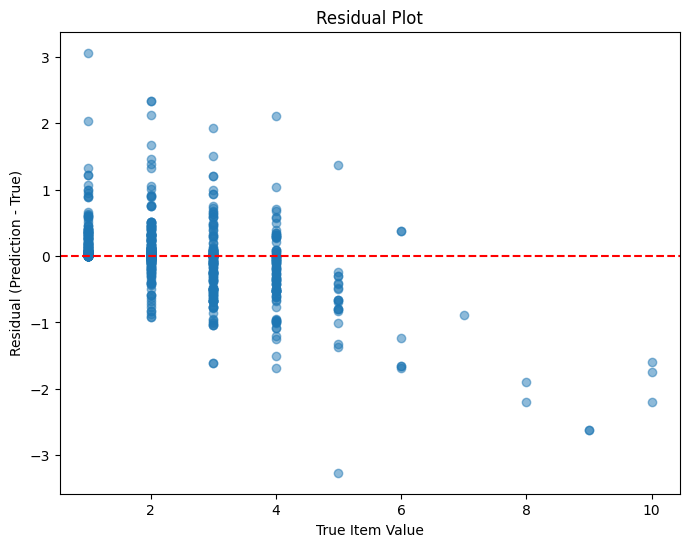

In [15]:
import matplotlib.pyplot as plt

y_true = y.values
y_pred = model.predict(X)

residuals = y_pred - y_true

plt.figure(figsize=(8,6))
plt.scatter(y_true, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Item Value")
plt.ylabel("Residual (Prediction - True)")
plt.title("Residual Plot")
plt.show()


In [16]:
filtered = df[df["value"] == 10]

summary = filtered.apply(
    lambda row: {k: v for k, v in row.items() if v != 0},
    axis=1
)

print(summary.to_list())


[{'message': 'WTS 10DB', 'name': 'Rapier', 'rarity': 8, 'id': 'Rapier_8001', 'pp_Effect_PhysicalWeaponDamage': 1.0, 'pp_Effect_MoveSpeed': 1.0, 'sp_Effect_Agility': 1.0, 'sp_Effect_MaxHealthAdd': 1.0, 'sp_Effect_MagicalInteractionSpeed': 0.55, 'sp_Effect_ArmorPenetration': 0.75, 'sp_Effect_BuffDurationBonus': 0.8666666666666666, 'sp_Effect_Will': 1.0, 'value': 10}, {'message': ' 10db', 'name': 'Rapier', 'rarity': 8, 'id': 'Rapier_8001', 'pp_Effect_PhysicalWeaponDamage': 1.0, 'pp_Effect_MoveSpeed': 1.0, 'sp_Effect_DemonReductionMod': 0.9, 'sp_Effect_SpellCastingSpeed': 0.75, 'sp_Effect_DemonDamageMod': 0.95, 'sp_Effect_MemoryCapacityBonus': 0.8, 'sp_Effect_Will': 1.0, 'sp_Effect_MagicPenetration': 0.7, 'value': 10}, {'message': ' 10db', 'name': 'Rapier', 'rarity': 8, 'id': 'Rapier_8001', 'pp_Effect_PhysicalWeaponDamage': 1.0, 'pp_Effect_MoveSpeed': 1.0, 'sp_Effect_Luck': 0.7666666666666667, 'sp_Effect_PhysicalWeaponDamageAdd': 1.0, 'sp_Effect_HeadshotDamageMod': 0.6, 'sp_Effect_ArmorPen

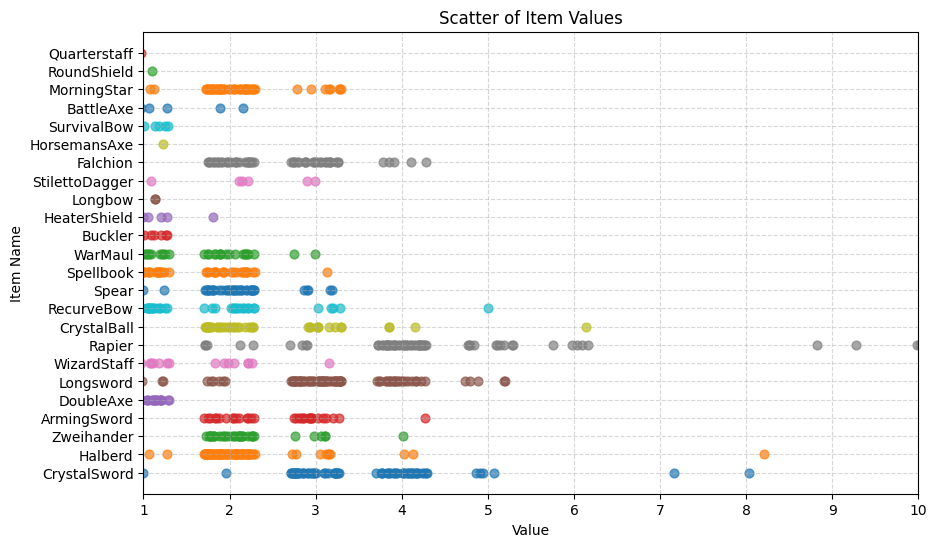

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))

# Amount of horizontal jitter
jitter_amount = 0.3

for item in df['name'].unique():
    item_values = df.loc[df['name'] == item, 'value']
    jittered_values = item_values + np.random.uniform(-jitter_amount, jitter_amount, size=len(item_values))
    plt.scatter(jittered_values, [item]*len(item_values), s=40, alpha=0.7)

plt.xlabel("Value")
plt.ylabel("Item Name")
plt.title("Scatter of Item Values")
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(1, 10)

plt.show()
